In [10]:
import os
import platform
import random
import shutil

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
 
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor 
from torch.cuda.amp import autocast, GradScaler 
from torchvision.utils import draw_bounding_boxes, save_image

import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import torchvision.transforms.functional as F

import labelme2coco
from pycocotools.coco import COCO

import pandas as pd 
import warnings 
warnings.filterwarnings("ignore")

In [11]:
if platform.system() == 'Darwin':
    device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cpu


In [12]:
HOME_DIR = '/Users/cucum/Downloads/COS40007'
os.chdir(HOME_DIR) 
DATASETS_DIR = f'{HOME_DIR}/week 5'
DATA_DIR = f'{DATASETS_DIR}/train'
NO_RUST_DATASET_FOLDER = f'{DATA_DIR}/no rust'
RUST_DATASET_FOLDER = f'{DATA_DIR}/rust'
TEST_DIR = f'{DATASETS_DIR}/test'
LOG_LABEL_DATASET_FOLDER = f'{DATASETS_DIR}/log-labelled'
COCO_ANNOTATIONS_DIR = f'{DATASETS_DIR}/coco_annotations'

MY_LOG_LABEL_DATASET_FOLDER = f'{DATASETS_DIR}/log-labelled'
MY_COCO_ANNOTATIONS_DIR = f'{DATASETS_DIR}/coco_annotations'

os.makedirs(TEST_DIR, exist_ok=True)
os.makedirs(f'{TEST_DIR}/no rust', exist_ok=True)
os.makedirs(f'{TEST_DIR}/rust', exist_ok=True)
os.makedirs(COCO_ANNOTATIONS_DIR, exist_ok=True)
os.makedirs(MY_COCO_ANNOTATIONS_DIR, exist_ok=True)

print(f'HOME_DIR: {HOME_DIR}')
print(f'DATASETS_DIR: {DATASETS_DIR}')
print(f'DATA_DIR: {DATA_DIR}') 
print(f'TEST_DIR: {TEST_DIR}')
print(f'RUST_DATASET_FOLDER: {RUST_DATASET_FOLDER}')
print(f'NO_RUST_DATASET_FOLDER: {NO_RUST_DATASET_FOLDER}')
print(f'COCO_ANNOTATIONS_DIR: {COCO_ANNOTATIONS_DIR}')

HOME_DIR: /Users/cucum/Downloads/COS40007
DATASETS_DIR: /Users/cucum/Downloads/COS40007/week 5
DATA_DIR: /Users/cucum/Downloads/COS40007/week 5/train
TEST_DIR: /Users/cucum/Downloads/COS40007/week 5/test
RUST_DATASET_FOLDER: /Users/cucum/Downloads/COS40007/week 5/train/rust
NO_RUST_DATASET_FOLDER: /Users/cucum/Downloads/COS40007/week 5/train/no rust
COCO_ANNOTATIONS_DIR: /Users/cucum/Downloads/COS40007/week 5/coco_annotations


In [13]:
# Set directory
labelme_folder = LOG_LABEL_DATASET_FOLDER
export_dir = COCO_ANNOTATIONS_DIR

# Convert LabelMe annotations to COCO format
train_split_rate = 0.5  # 50% for training
category_id_start = 1  # Start category IDs from 1
labelme2coco.convert(labelme_folder, export_dir, train_split_rate, category_id_start=category_id_start)

print("LabelMe annotations converted to COCO format for log detection.")

There are 600 listed files in folder /Users/cucum/Downloads/COS40007/week 5/log-labelled.


Converting labelme annotations to COCO format: 100%|██████████| 600/600 [00:04<00:00, 147.17it/s]
10/23/2024 19:53:36 - INFO - labelme2coco -   Training split in COCO format is exported to \Users\cucum\Downloads\COS40007\week 5\coco_annotations\train.json
10/23/2024 19:53:36 - INFO - labelme2coco -   Validation split in COCO format is exported to \Users\cucum\Downloads\COS40007\week 5\coco_annotations\val.json


LabelMe annotations converted to COCO format for log detection.


In [14]:
# Custom COCO dataset class
class COCODataset(Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.transforms = transforms

    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)
        img_info = coco.loadImgs(img_id)[0]
        path = img_info['file_name']

        # Load image
        img_path = os.path.join(self.root, path)
        img = Image.open(img_path).convert('RGB')

        # Load annotations
        num_objs = len(anns)
        boxes = []
        labels = []
        masks = []

        for ann in anns:
            xmin = ann['bbox'][0]
            ymin = ann['bbox'][1]
            width = ann['bbox'][2]
            height = ann['bbox'][3]
            xmax = xmin + width
            ymax = ymin + height
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(ann['category_id'])
            masks.append(coco.annToMask(ann))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(np.stack(masks, axis=0), dtype=torch.uint8)

        image_id = torch.tensor([img_id])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['masks'] = masks
        target['image_id'] = image_id
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.ids)

In [15]:
# Transformations
transform = transforms.Compose([
    transforms.ToTensor()
])

# Paths to images and COCO annotations
images_dir = LOG_LABEL_DATASET_FOLDER
train_json = os.path.join(COCO_ANNOTATIONS_DIR, 'train.json')
val_json = os.path.join(COCO_ANNOTATIONS_DIR, 'val.json')

# Dataset instances
train_dataset = COCODataset(root=images_dir, annotation=train_json, transforms=transform)
val_dataset = COCODataset(root=images_dir, annotation=val_json, transforms=transform)

# Collate Function
def collate_fn(batch):
    return tuple(zip(*batch))

# DataLoader instances
train_loader = DataLoader(
    train_dataset,
    batch_size=1,       
    shuffle=True,
    num_workers=0,     
    collate_fn=collate_fn  
)

val_loader = DataLoader(
    val_dataset,
    batch_size=1,      
    shuffle=False,
    num_workers=0,      
    collate_fn=collate_fn  
)

print("Datasets loaded successfully for Mask R-CNN training.")

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Datasets loaded successfully for Mask R-CNN training.


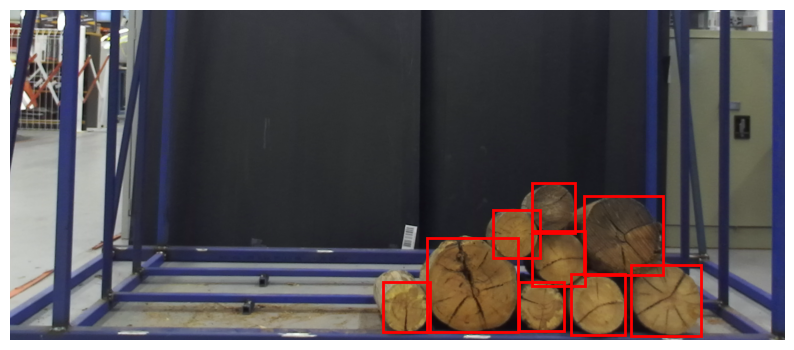

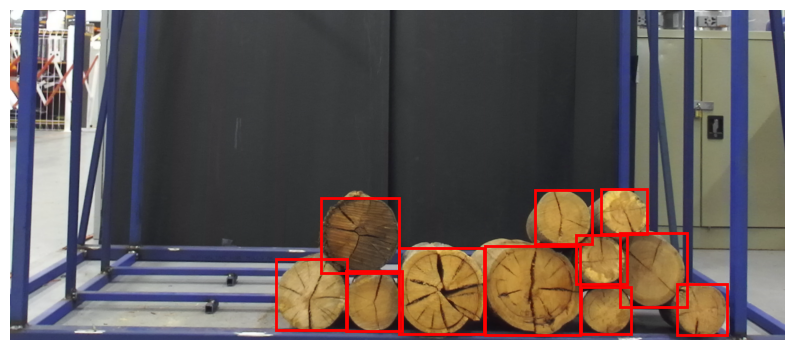

In [16]:
# Visualize a sample from the COCO dataset
def visualize_sample(dataset, index=None):
    if index is None:
        index = random.randint(0, len(dataset) - 1)
    
    img, target = dataset[index]
    img = img.permute(1, 2, 0).numpy()
    
    boxes = target['boxes'].numpy()
    labels = target['labels'].numpy()
    masks = target['masks'].numpy()
    
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    
    ax = plt.gca()
    
    for box in boxes:
        xmin, ymin, xmax, ymax = box
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color='red', linewidth=2)
        ax.add_patch(rect)
    
    plt.axis('off')
    plt.show()

# Visualize a random training sample
visualize_sample(train_dataset)
visualize_sample(val_dataset)

In [17]:
import torch
from torch import nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torchvision.models.detection import maskrcnn_resnet50_fpn

# Define a custom Fast R-CNN predictor compatible with the Mask R-CNN
class CustomFastRCNNPredictor(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CustomFastRCNNPredictor, self).__init__()
        # Classification layer
        self.cls_score = nn.Linear(in_channels, num_classes)
        # Bounding box regression layer
        self.bbox_pred = nn.Linear(in_channels, num_classes * 4)

    def forward(self, x):
        class_logits = self.cls_score(x)
        box_regression = self.bbox_pred(x)
        return class_logits, box_regression

# Model and Device Setup
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2  # 1 class ('log') + background
maskrcnn = maskrcnn_resnet50_fpn(weights="DEFAULT")

# Adjust number of classes for box predictor
in_features = maskrcnn.roi_heads.box_predictor.cls_score.in_features
maskrcnn.roi_heads.box_predictor = CustomFastRCNNPredictor(in_features, num_classes)

# Adjust number of classes for mask predictor
in_features_mask = maskrcnn.roi_heads.mask_predictor.conv5_mask.in_channels
maskrcnn.roi_heads.mask_predictor = nn.Conv2d(in_features_mask, num_classes, kernel_size=1)

maskrcnn.to(device)

# Load a smaller subset of the dataset for testing
train_dataset = torch.utils.data.Subset(train_dataset, range(10))

# DataLoader setup
train_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    collate_fn=collate_fn
)

# Optimizer setup
optimizer = AdamW([p for p in maskrcnn.parameters() if p.requires_grad], lr=0.001)

# Model path to save the trained model
model_path = 'week 5/models/mask_rcnn_resnet50_log_detector.pth'

# Training Loop
num_epochs = 2
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs} {'-'*40}")
    maskrcnn.train()
    
    for step, (images, targets) in enumerate(train_loader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = maskrcnn(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        print(f"Step {step + 1}, Loss: {losses.item()}")

# Save the trained model
torch.save(maskrcnn.state_dict(), model_path)
print(f"\nMask R-CNN model trained and saved at {model_path}.")


Epoch 1/2 ----------------------------------------
Step 1, Loss: 2.688889741897583
Step 2, Loss: 5.14037561416626
Step 3, Loss: 13.007333755493164
Step 4, Loss: 2.9251277446746826
Step 5, Loss: 4.000322341918945

Epoch 2/2 ----------------------------------------
Step 1, Loss: 38.09626007080078
Step 2, Loss: 1.790063500404358
Step 3, Loss: 1.7694051265716553
Step 4, Loss: 1.4571000337600708
Step 5, Loss: 3.570687770843506

Mask R-CNN model trained and saved at week 5/models/mask_rcnn_resnet50_log_detector.pth.


No boxes with confidence score above threshold.


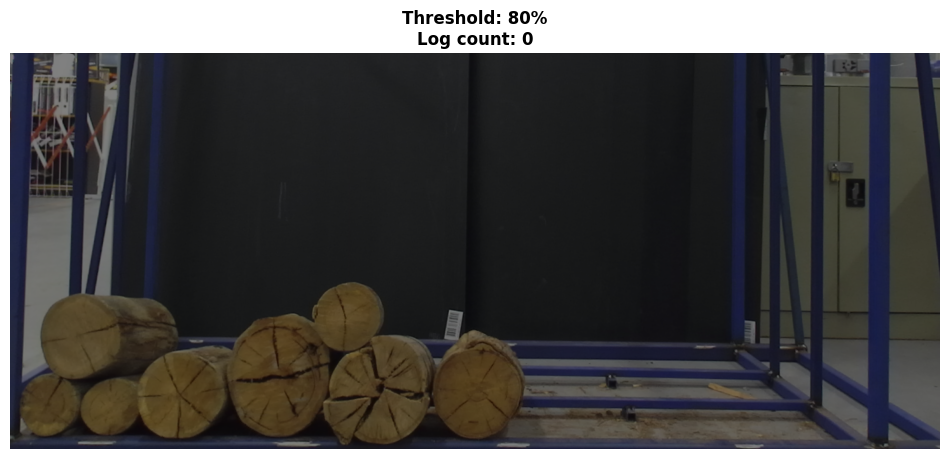

No boxes with confidence score above threshold.


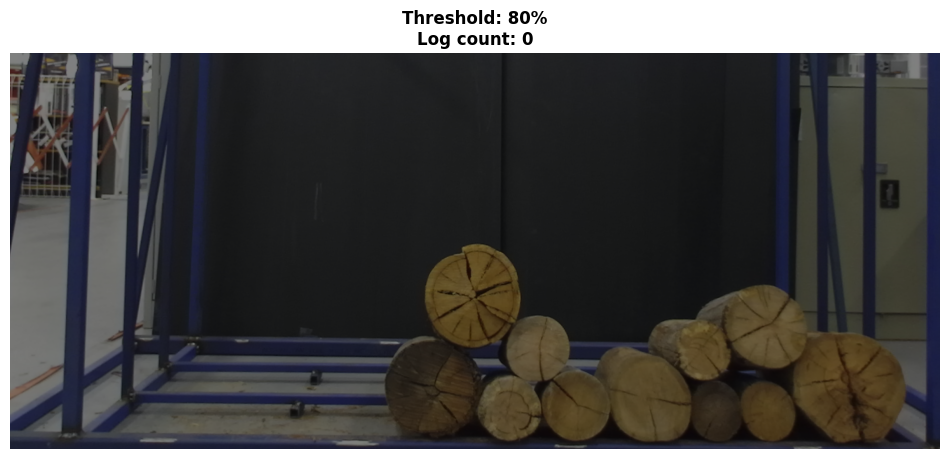

No boxes with confidence score above threshold.


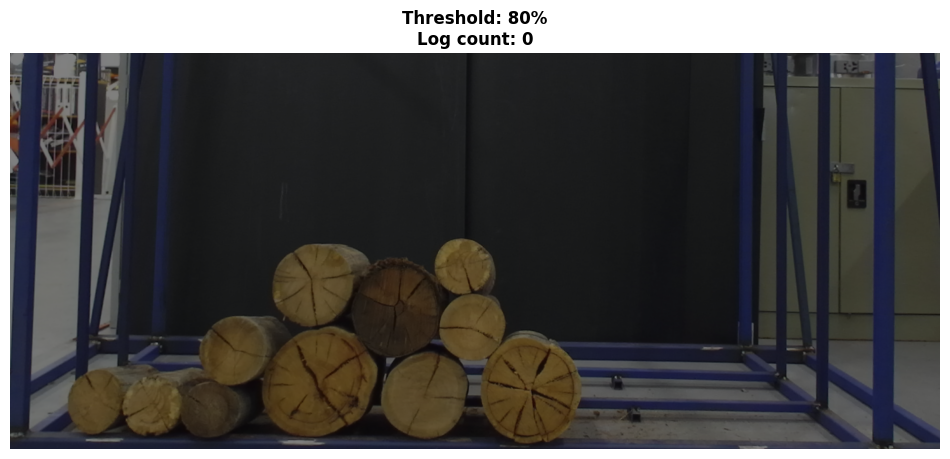

No boxes with confidence score above threshold.


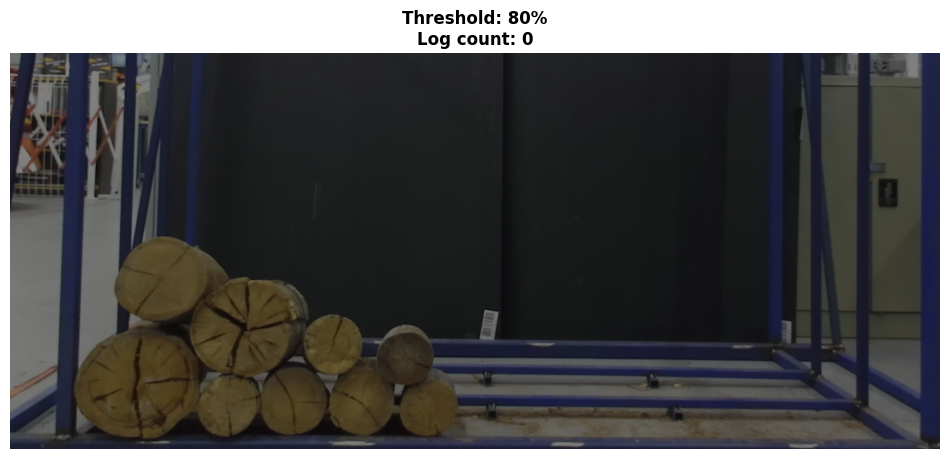

No boxes with confidence score above threshold.


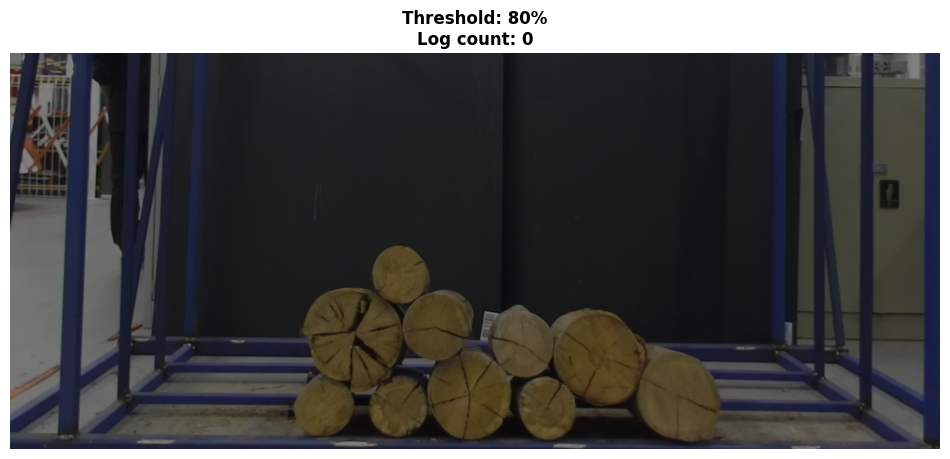

No boxes with confidence score above threshold.


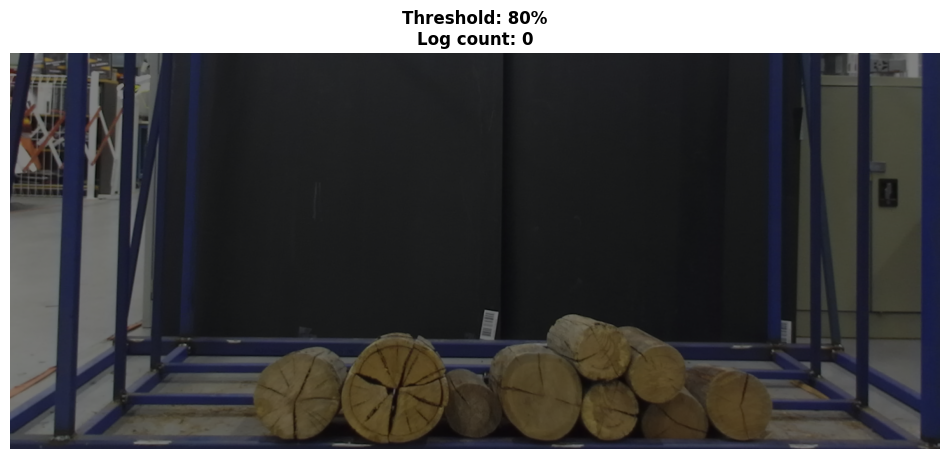

No boxes with confidence score above threshold.


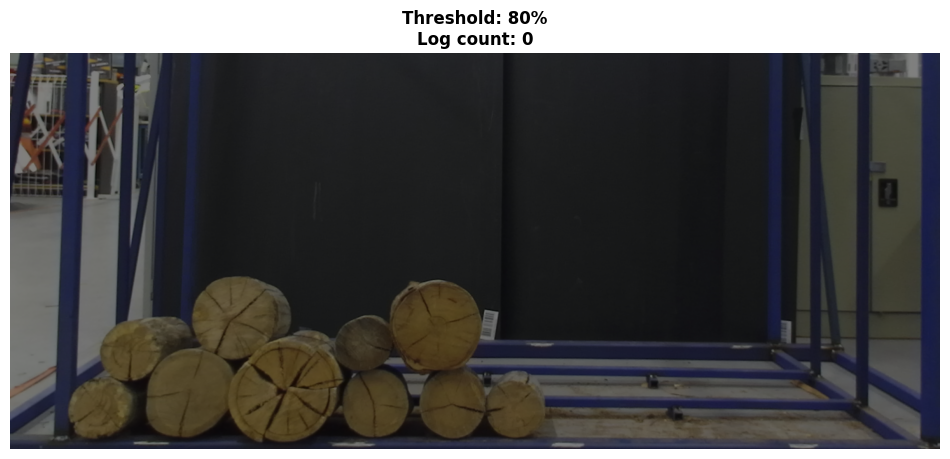

No boxes with confidence score above threshold.


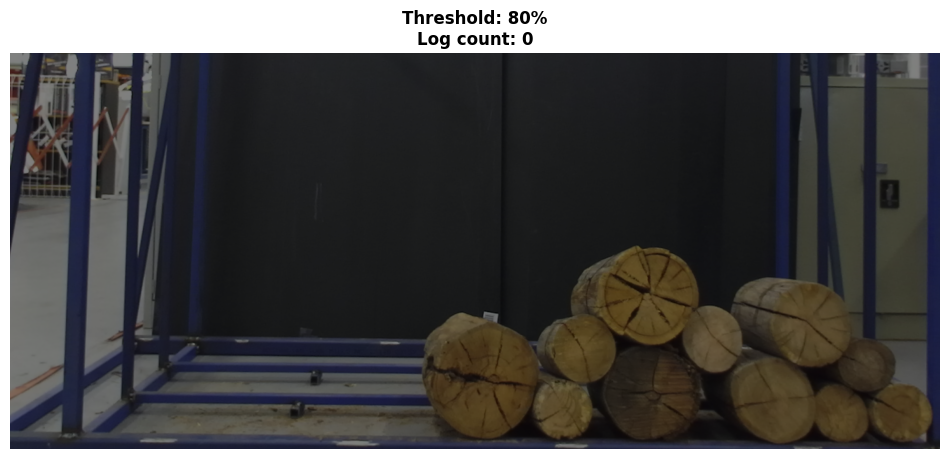

No boxes with confidence score above threshold.


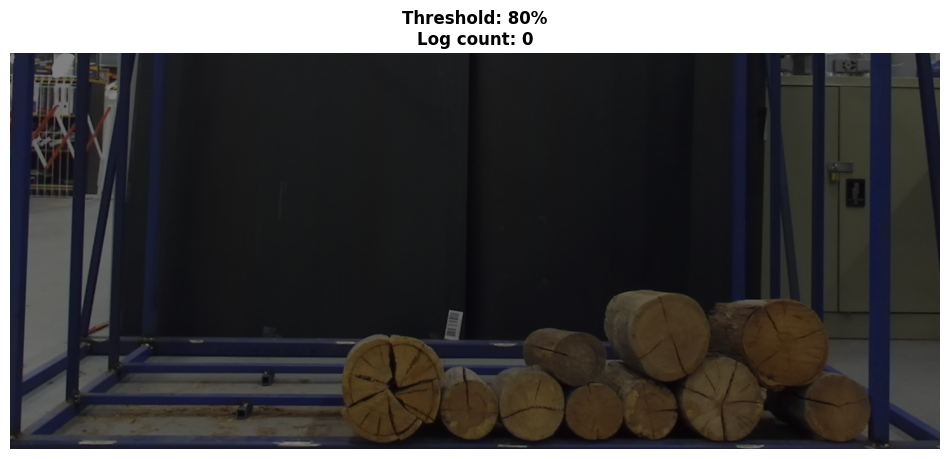

No boxes with confidence score above threshold.


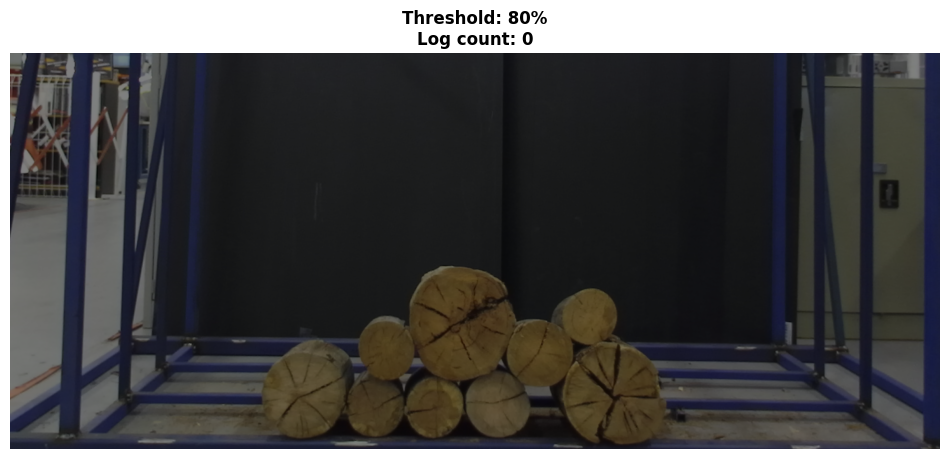

Validation and visualization completed in 44.74 seconds.


In [18]:
import torch
from PIL import ImageDraw, ImageFont
import torchvision.transforms.functional as F
import os
import numpy as np
import matplotlib.pyplot as plt
import time

# Set up timing and output folder
time_start = time.time()
os.makedirs('week-05-portfolio/rcnn_test', exist_ok=True)

def visualize_predictions(image, output, score_threshold=0.8, save_path=None):
    """
    Visualize predicted bounding boxes, masks, and labels with confidence score threshold.
    """
    # Convert image to [0-255] range for visualization
    image = (image * 255).byte()

    # Extract bounding boxes, labels, scores, and masks from output
    pred_boxes = output['boxes'].detach().cpu()
    pred_labels = output['labels'].detach().cpu()
    pred_scores = output['scores'].detach().cpu()
    pred_masks = output['masks'].detach().cpu()

    # Filter predictions by confidence score
    high_conf_indices = pred_scores >= score_threshold
    pred_boxes = pred_boxes[high_conf_indices]
    pred_labels = pred_labels[high_conf_indices]
    pred_scores = pred_scores[high_conf_indices]
    pred_masks = pred_masks[high_conf_indices]

    # Count the number of logs
    log_count = (pred_labels == 1).sum().item()

    if len(pred_boxes) == 0:
        print("No boxes with confidence score above threshold.")
    else:
        print(f"Log count: {log_count}")

    # Convert image tensor to PIL for drawing
    image_pil = F.to_pil_image(image)
    draw = ImageDraw.Draw(image_pil)

    # Define font for labels
    try:
        font = ImageFont.truetype("arialbd.ttf", size=20)
    except IOError:
        font = ImageFont.load_default()

    # Draw bounding boxes and labels
    for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
        xmin, ymin, xmax, ymax = box
        draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=2)
        label_text = f"Log {label.item()} ({score:.2f})"
        draw.text((xmin, ymin - 10), label_text, fill="white", font=font)

    # Create an overlay for the masks
    image_array = np.array(image_pil)
    mask_overlay = np.zeros_like(image_array, dtype=np.uint8)

    for mask in pred_masks:
        mask = mask.squeeze(0).numpy()
        mask = (mask * 255).astype(np.uint8)
        mask_overlay[:, :, 0] += mask  # Add mask to red channel for visualization

    # Plot the image with bounding boxes and masks
    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.imshow(image_pil)
    ax.imshow(mask_overlay, alpha=0.5, cmap='Reds')
    
    # Add title with confidence threshold and log count
    ax.set_title(
        f"Threshold: {score_threshold * 100:.0f}%\nLog count: {log_count}", 
        fontsize=12, fontweight='bold'
    )
    plt.axis("off")

    # Save the image if a save path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')

    # Display the image
    plt.show()

# Ensure the Mask R-CNN model is loaded and set to evaluation mode
maskrcnn.eval()

# Annotate and visualize 10 images from the test set
num_visualized = 0
with torch.no_grad():
    for images, targets in val_loader:  # Make sure val_loader is defined properly
        # Move images to device
        images = [image.to(device) for image in images]

        # Use mixed precision for inference (if supported)
        with torch.cuda.amp.autocast():
            outputs = maskrcnn(images)

        for i in range(len(images)):
            # Save and visualize the prediction outcome images
            save_path = os.path.join('week-05-portfolio/rcnn_test', f"image_{num_visualized + 1}.png")
            visualize_predictions(images[i].cpu(), outputs[i], score_threshold=0.8, save_path=save_path)

            num_visualized += 1
            if num_visualized >= 10:  # Limit to 10 images
                break

        if num_visualized >= 10:  # Exit loop after visualizing 10 images
            break

# End timing and print total duration
time_end = time.time()
print(f"Validation and visualization completed in {time_end - time_start:.2f} seconds.")
